In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

C:\Users\flash\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [8]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0 #

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        action = self.action_from_int(action)
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# Q-learning

In [9]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.3, gamma=0.9):
    env.reset()
    current_state = env.getHash()
    done = False        
    s, a = current_state, get_pi(current_state) if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        if (env.curTurn == 1) and (reward != -10):
            reward = -reward
        s_prime, a_prime = observation[0], get_pi(observation[0]) if np.random.rand() > epsilon else np.random.randint(nA)
        current_Q = get_Q(s)
        Q_prime = get_Q(s_prime)
        
        t = Q[s][a] + alpha * (reward + gamma * np.max( Q_prime ) - Q[s][a])
        q_current = []
        for i in range(a):
            q_current.append(Q[s][i])
        q_current.append(t)
        for i in range(a+1, len(Q[s])):
            q_current.append(Q[s][i])

        Q.update({s:q_current})
        s, a = s_prime, a_prime
        if done:
            break
            
def get_random_Q(env):
    nA = env.action_space.n
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    return Q

def get_Q(board_hash):
        if board_hash in Q:
            qvals = Q[board_hash]
        else:
            qvals = np.full(N_COLS*N_ROWS, 0)
            Q[board_hash] = qvals
        return qvals
    
def get_pi(board_hash):
        qvals = get_Q(board_hash)
        return np.argmax(qvals)
    
def compute_policy_by_Q(Q, pi, gamma=1.0):
    for state in Q:
        pi.update({state: np.argmax(Q[state])})
    return pi    
    

In [10]:
def get_one_move(env, pi, s, actions, random=False):
    '''Делаем ход'''
    if random:
        act = np.random.randint(len(actions))
        return env.int_from_action(actions[act])
    else:
        return get_pi(s)

In [11]:
def test_game(env, pi1, pi2, random_crosses=False, random_naughts=True):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_one_move(env, pi1, s, actions, random=random_crosses)
        else:
            a = get_one_move(env, pi2, s, actions, random=random_naughts)
        observation, reward, done, info = env.step(a)
    return reward

# Обучим и протестируем для доски 3х3

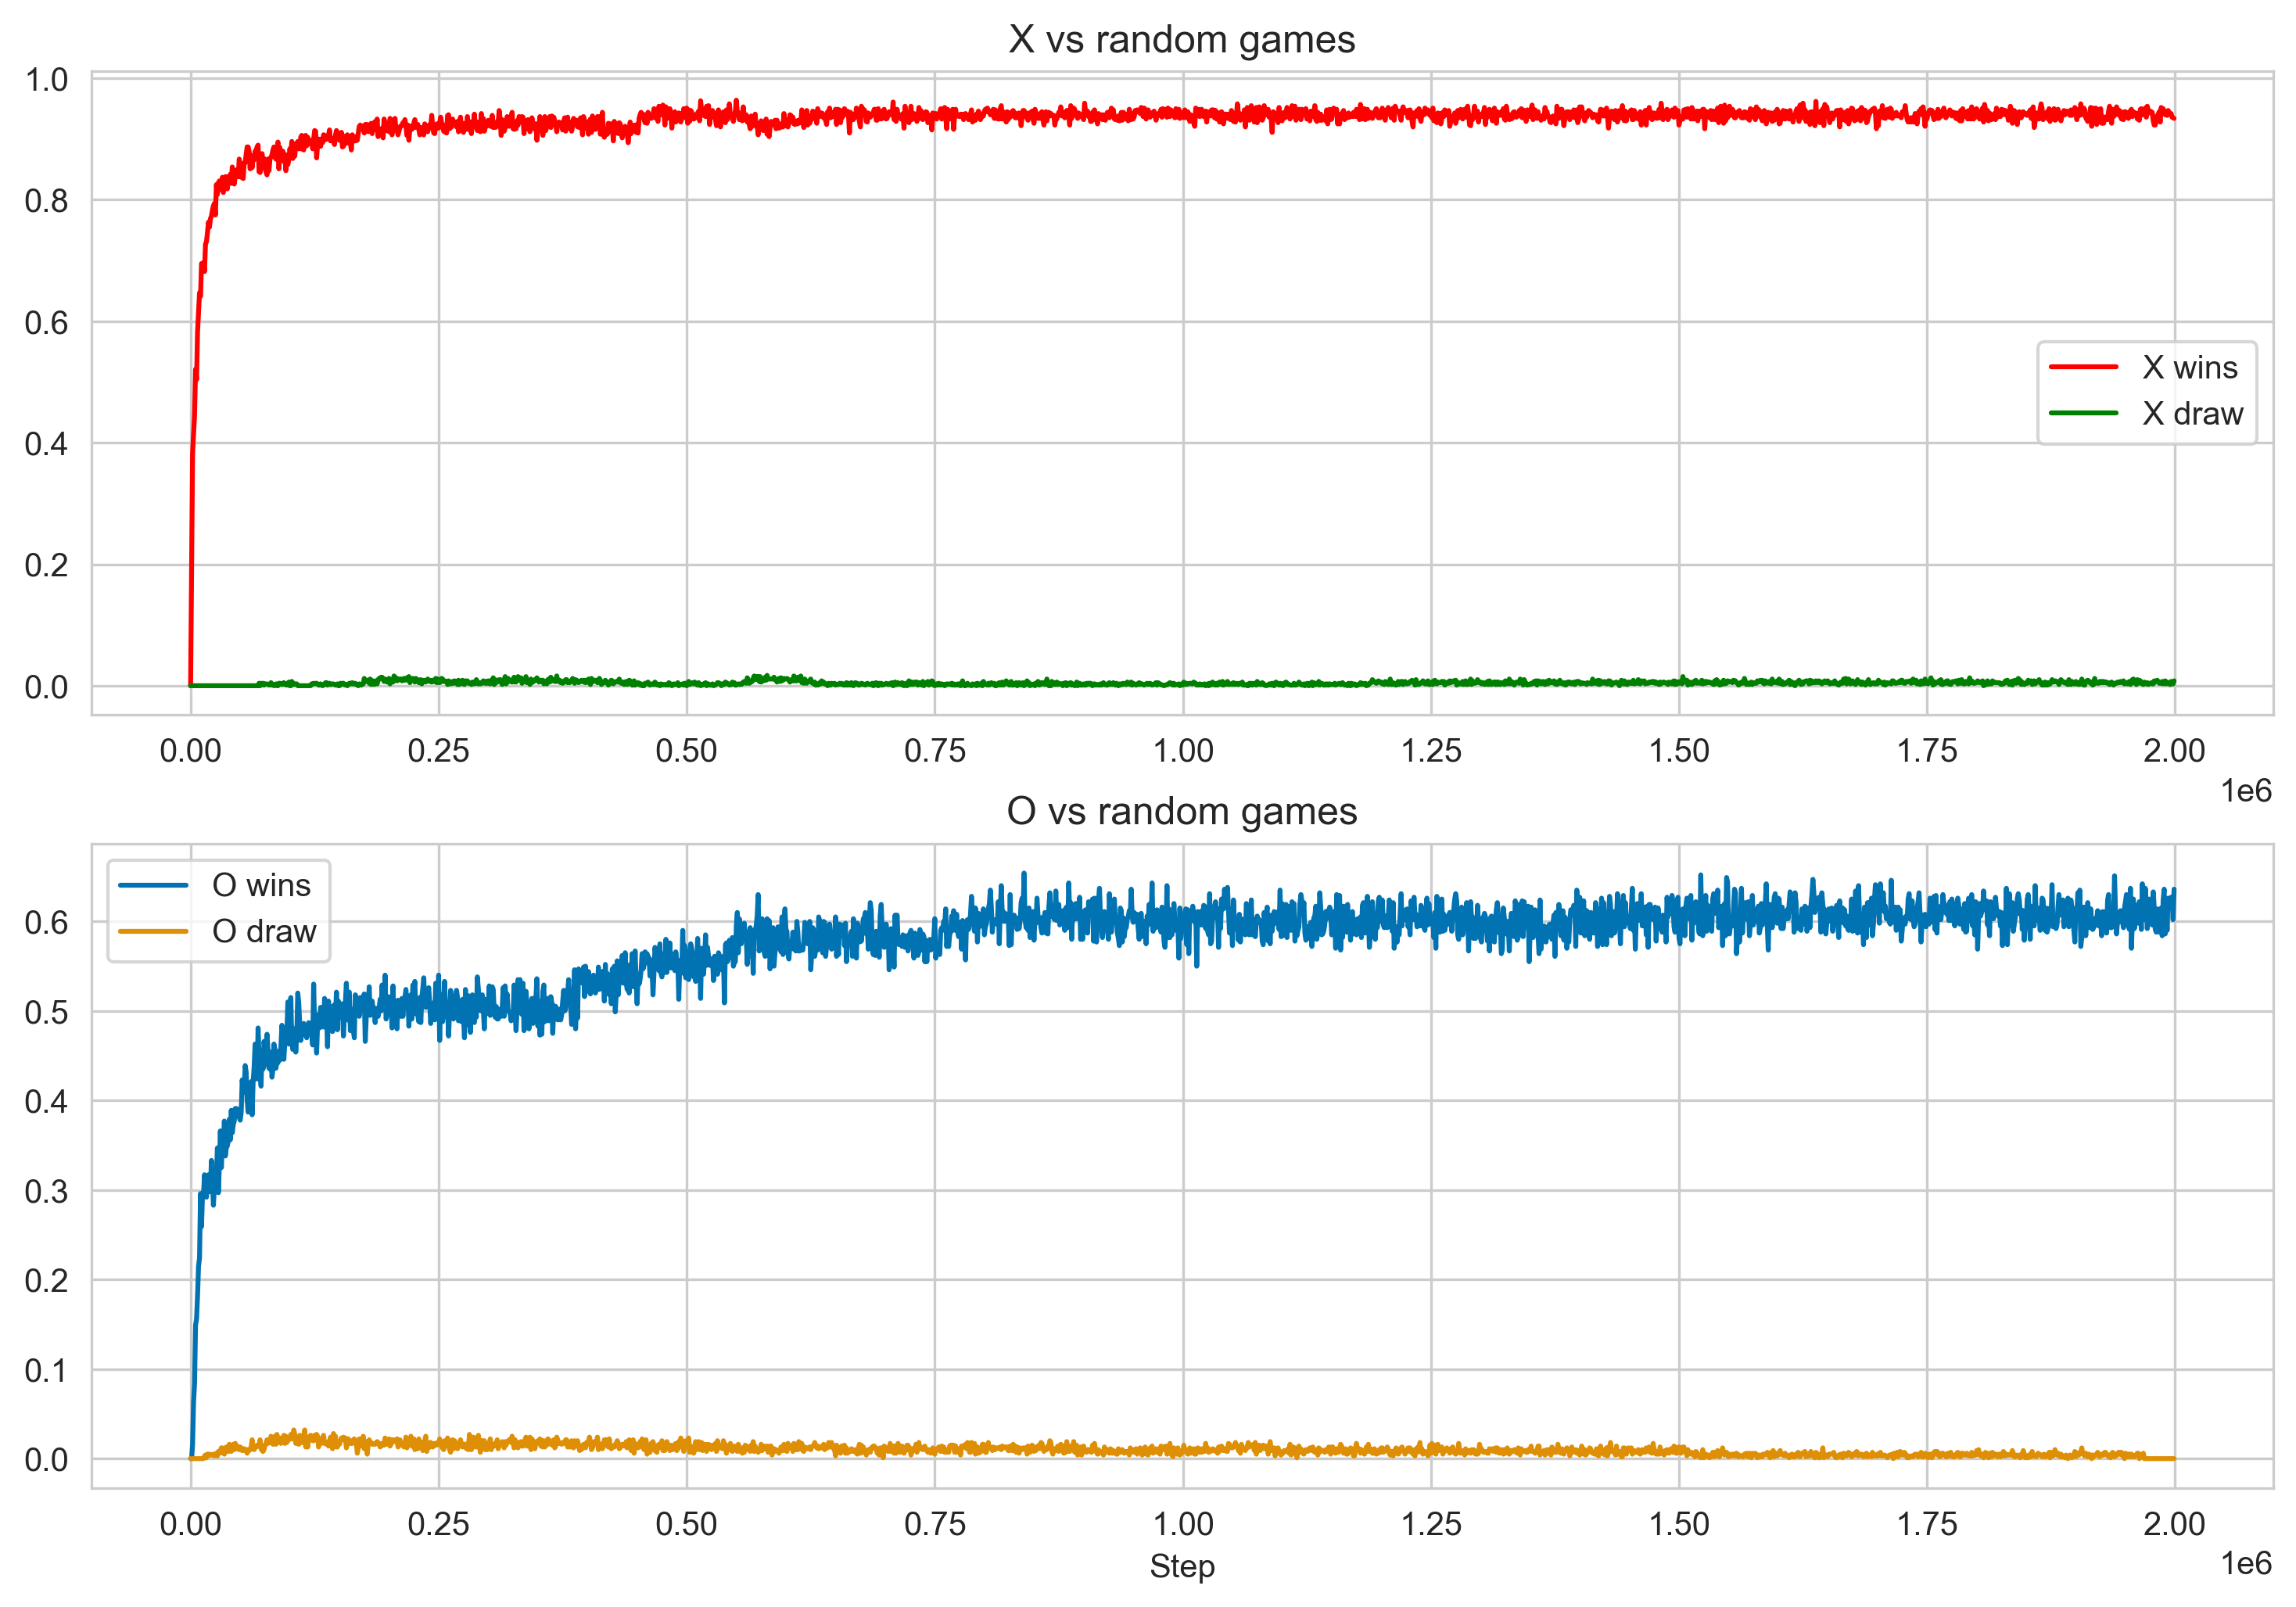

In [349]:
total_episodes = 2000000
test_episodes = 1000
gamma = 0.8
from IPython.display import clear_output
N_ROWS, N_COLS, N_WIN = 3, 3, 3
Q_hist_Qlearn = [ ]
Q = {}
pi = {}
nA = N_COLS * N_ROWS
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []

env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
episodes = []
for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.5, gamma=gamma)
    #pi = compute_policy_by_Q(Q, pi)
    Q_hist_Qlearn.append(np.copy(Q))
    if (n % 1000 == 0):
        crosses_wins_counter, naughts_wins_counter, crosses_draw_counter, naughts_draw_counter = 0, 0, 0, 0

        for k in range(test_episodes):
            cross = test_game(env, pi, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
            elif cross == 0:
                crosses_draw_counter +=1
                
            naughts = test_game(env, None, pi, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
            elif naughts == 0:
                naughts_draw_counter +=1 
            
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        
        crosses_draw.append(crosses_draw_counter/test_episodes)
        naughts_draw.append(naughts_draw_counter/test_episodes)
        episodes.append(n)
        
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        clear_output(True)
        ax[0].plot(episodes, crosses_wins, 'r', label='X wins')
        ax[0].plot(episodes, crosses_draw, 'g', label='X draw')
        ax[0].set_title('X vs random games')
        ax[0].legend()
        ax[1].plot(episodes, naughts_wins, label='O wins')
        ax[1].plot(episodes, naughts_draw, label='O draw')
        ax[1].set_title('O vs random games')
        ax[1].set_xlabel('Step')
        plt.legend()
        plt.show()

env.close()


# И для доски 4х4

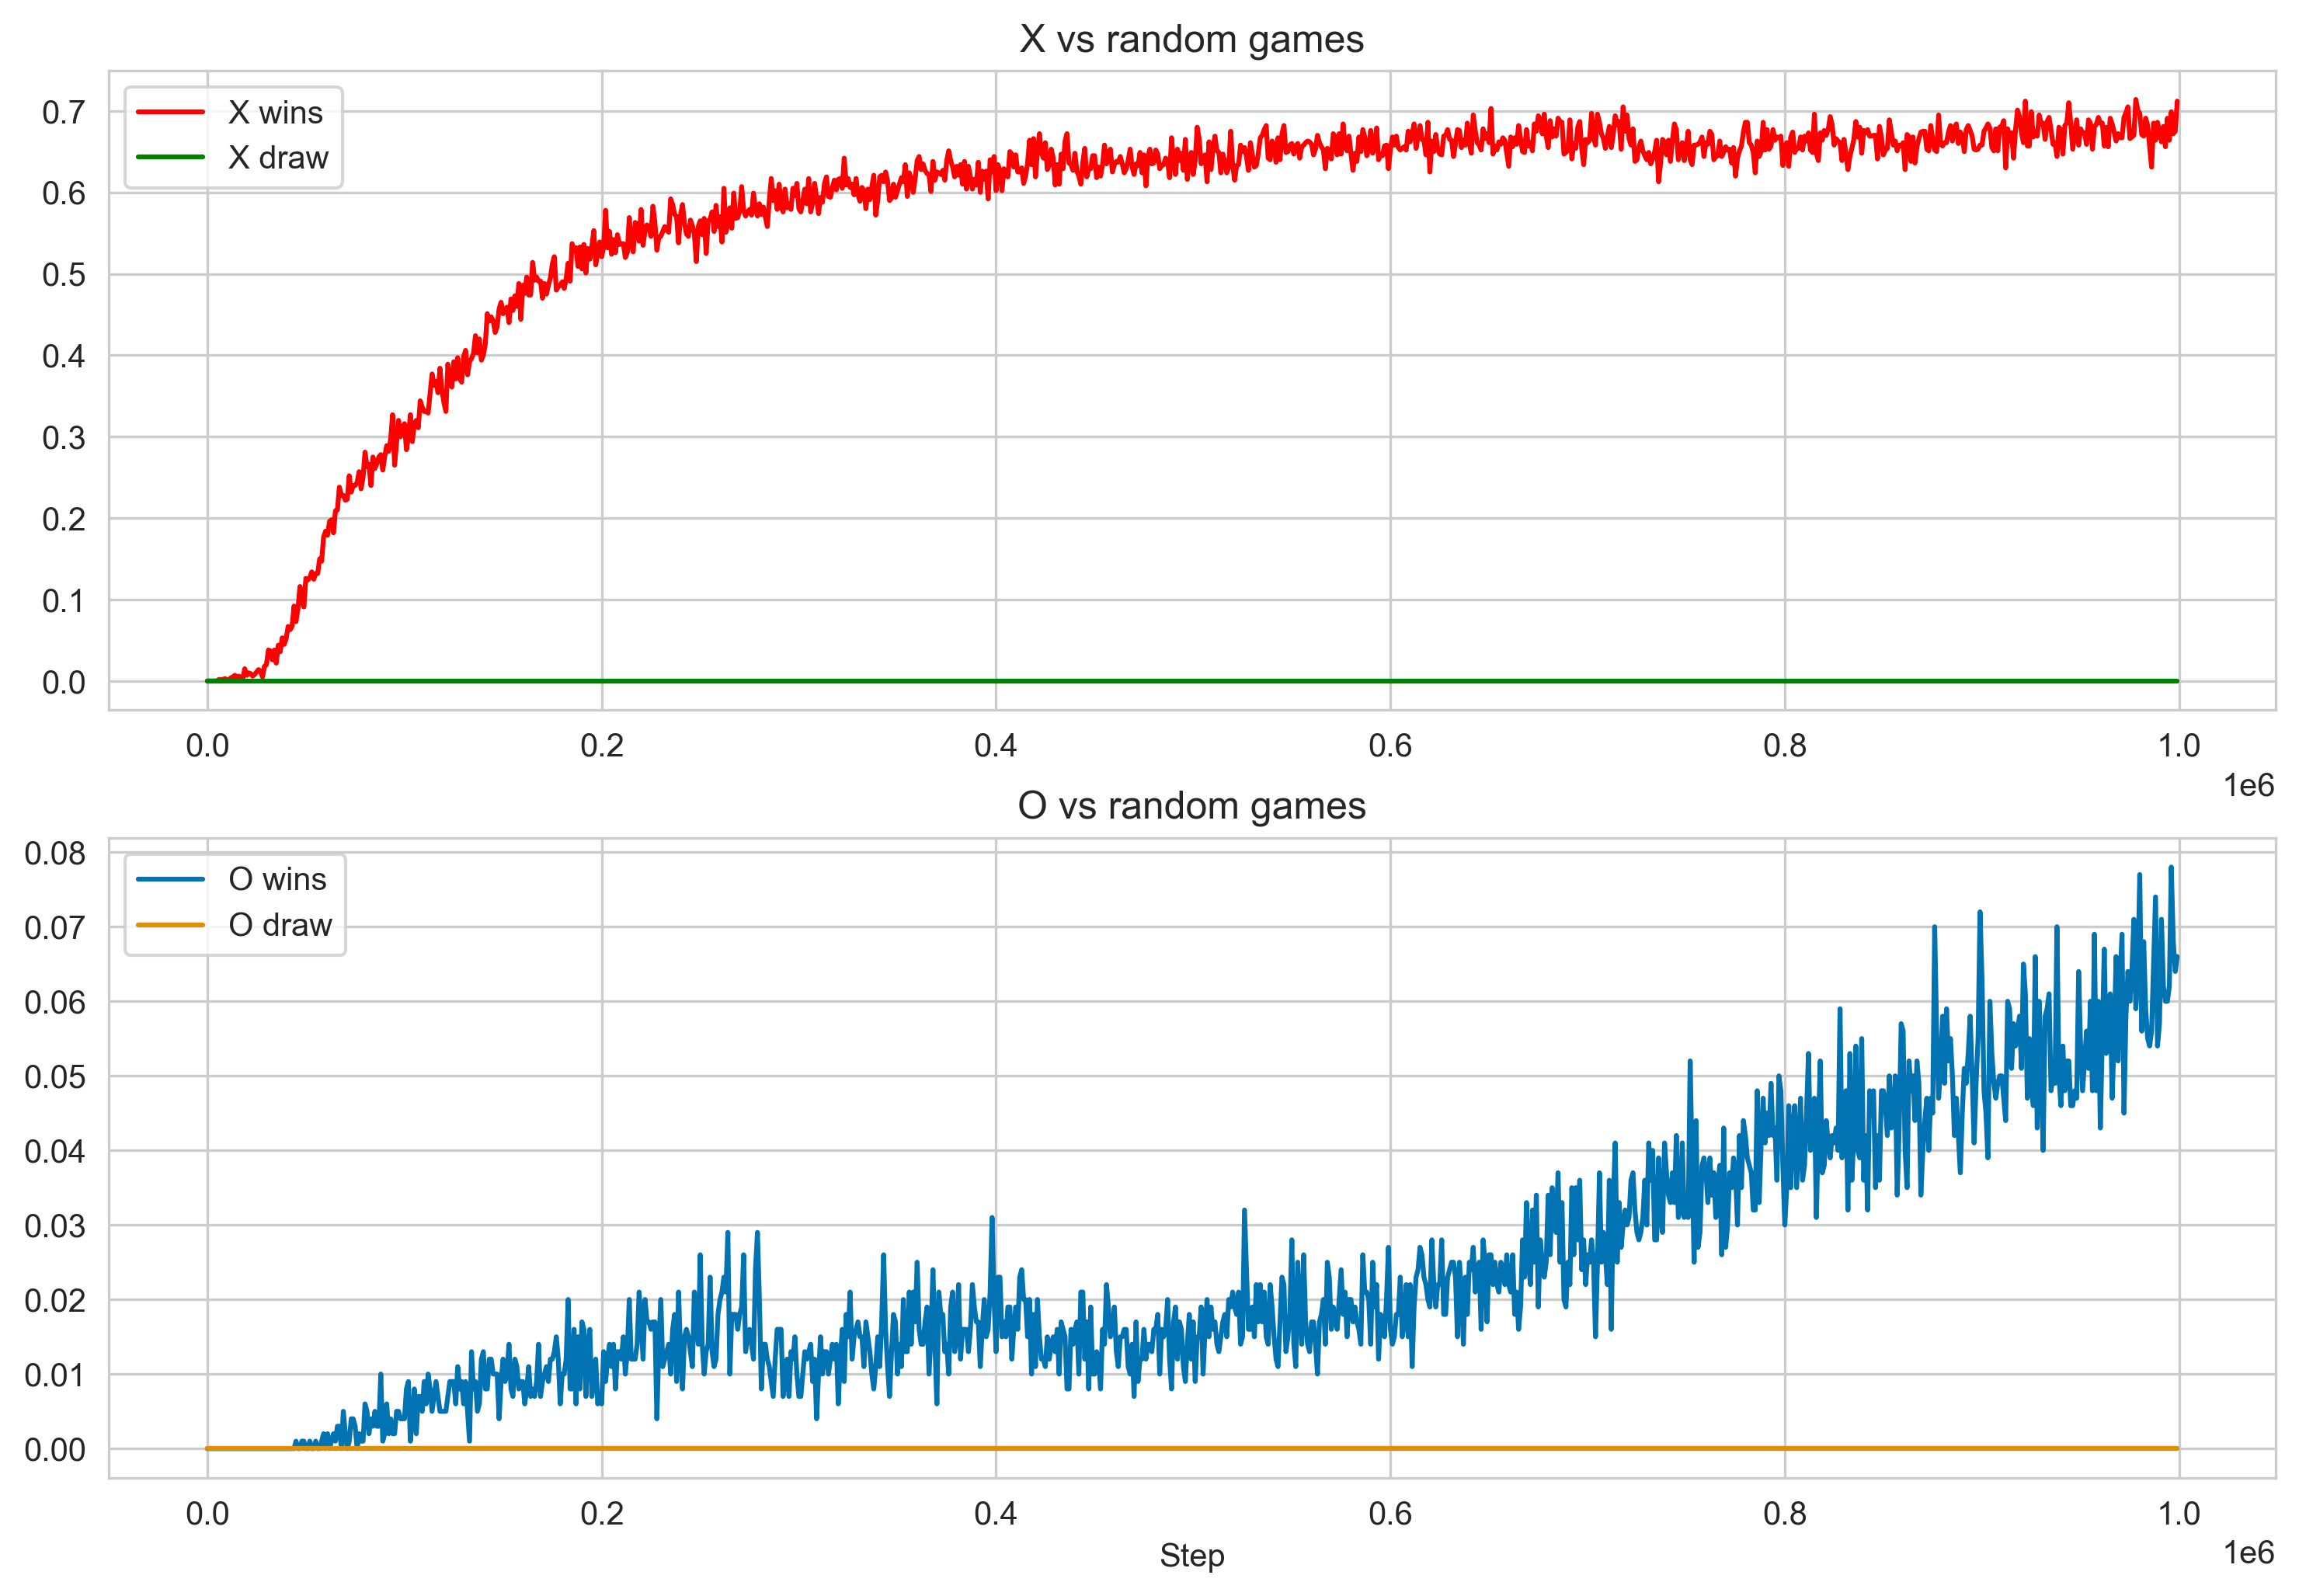

In [957]:
total_episodes = 1000000
test_episodes = 1000
gamma = 0.8
from IPython.display import clear_output
N_ROWS, N_COLS, N_WIN = 4, 4, 4
Q_hist_Qlearn = [ ]
Q = {}
pi = {}
nA = N_COLS * N_ROWS
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []

env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
episodes = []

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.5, gamma=gamma)
    #pi = compute_policy_by_Q(Q, pi)
    Q_hist_Qlearn.append(np.copy(Q))
    if (n % 1000 == 0):
        crosses_wins_counter, naughts_wins_counter, crosses_draw_counter, naughts_draw_counter = 0, 0, 0, 0

        for k in range(test_episodes):
            cross = test_game(env, pi, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
            elif cross == 0:
                crosses_draw_counter +=1
                
            naughts = test_game(env, None, pi, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
            elif naughts == 0:
                naughts_draw_counter +=1 
            
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        
        crosses_draw.append(crosses_draw_counter/test_episodes)
        naughts_draw.append(naughts_draw_counter/test_episodes)
        episodes.append(n)
        
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        clear_output(True)
        ax[0].plot(episodes, crosses_wins, 'r', label='X wins')
        ax[0].plot(episodes, crosses_draw, 'g', label='X draw')
        ax[0].set_title('X vs random games')
        ax[0].legend()
        ax[1].plot(episodes, naughts_wins, label='O wins')
        ax[1].plot(episodes, naughts_draw, label='O draw')
        ax[1].set_title('O vs random games')
        ax[1].set_xlabel('Step')
        plt.legend()
        plt.show()

env.close()

# DQN и DoubleDQN

In [396]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [873]:
def test_game_dqn(env, model1, model2, random_crosses=False, random_naughts=True):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_one_move_dqn(env, model1, s, israndom=random_crosses)
        else:
            a = get_one_move_dqn(env, model2, s, israndom=random_naughts)
        s, reward, done, info = env.step(a)
    return reward

In [958]:
def get_one_move_dqn(env, model, state, israndom=False):
    '''Делаем ход'''    
    if israndom:
        empty_spaces = env.getEmptySpaces()
        n_sp = random.randrange(len(empty_spaces))
        act = empty_spaces[n_sp][0] * env.n_cols + empty_spaces[n_sp][1]
        return torch.tensor([[act]], dtype=torch.int64)
    else:
        with torch.no_grad():
            state_matrix = [int(state[i]) for i in range(len(state))] + [env.curTurn]
            state_matrix = torch.tensor([state_matrix], dtype=torch.float32)
            t = model(state_matrix).data.max(1)[1]
            return t.view(1, 1)

In [959]:
class Network(nn.Module):
    def __init__(self, n_rows, n_cols):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear( n_rows * n_cols + 1, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, n_rows * n_cols)

    def forward(self, x):
        nn_input = F.relu(self.fc1(x))
        nn_input = F.relu(self.fc2(nn_input))
        nn_input = F.relu(self.fc3(nn_input))
        nn_input = F.relu(self.fc4(nn_input))
        return nn_input

In [960]:
class DQN():
    def __init__(self, n_rows, n_cols, n_win):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model = Network(n_rows, n_cols)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001) # 3x3: 0.001
        
        self.nrows = n_rows
        self.ncols = n_cols
        self.n_win = n_win
        
        self.gamma = 0.8
        self.steps_done = 0
        self.episode_durations = []
        self.batch_size = 128 # 3x3: 128
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 2000
        self.num_step = 0
        
    def select_greedy_action(self, state):
        t = self.model(state).data.max(1)[1]
        return t.view(1, 1)
    
    def state_to_matrix(self, state):
        state_matrix = [int(state[i]) for i in range(len(state))]
        return state_matrix+[self.env.curTurn]
    
    def select_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            n_sp = random.randrange(len(empty_spaces))
            act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
            return torch.tensor([[act]], dtype=torch.int64)
        
    def select_random_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        n_sp = random.randrange(len(empty_spaces))
        act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
        return torch.tensor([[act]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        state = self.env.getState()
        num_step = 0
        actions = []
        losses = []
        while True:
            state_tensor = torch.tensor([self.state_to_matrix(state[0])], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            if (self.env.curTurn == 1) and (reward == -1):
                reward = -reward
            
            next_state_tensor = torch.tensor([self.state_to_matrix(next_state[0])], dtype=torch.float32) 
            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            actions.append(action)
            self.memory.store(transition)

            if do_learning:
                losses.append(self.learn())

            state = next_state
            num_step += 1

            if done:
                return reward, losses
                #break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        # берём мини-батч из памяти
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward), requires_grad=True)
        batch_next_state = Variable(torch.cat(batch_next_state), requires_grad=True)

        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

# Обучим и протестируем для доски 3х3

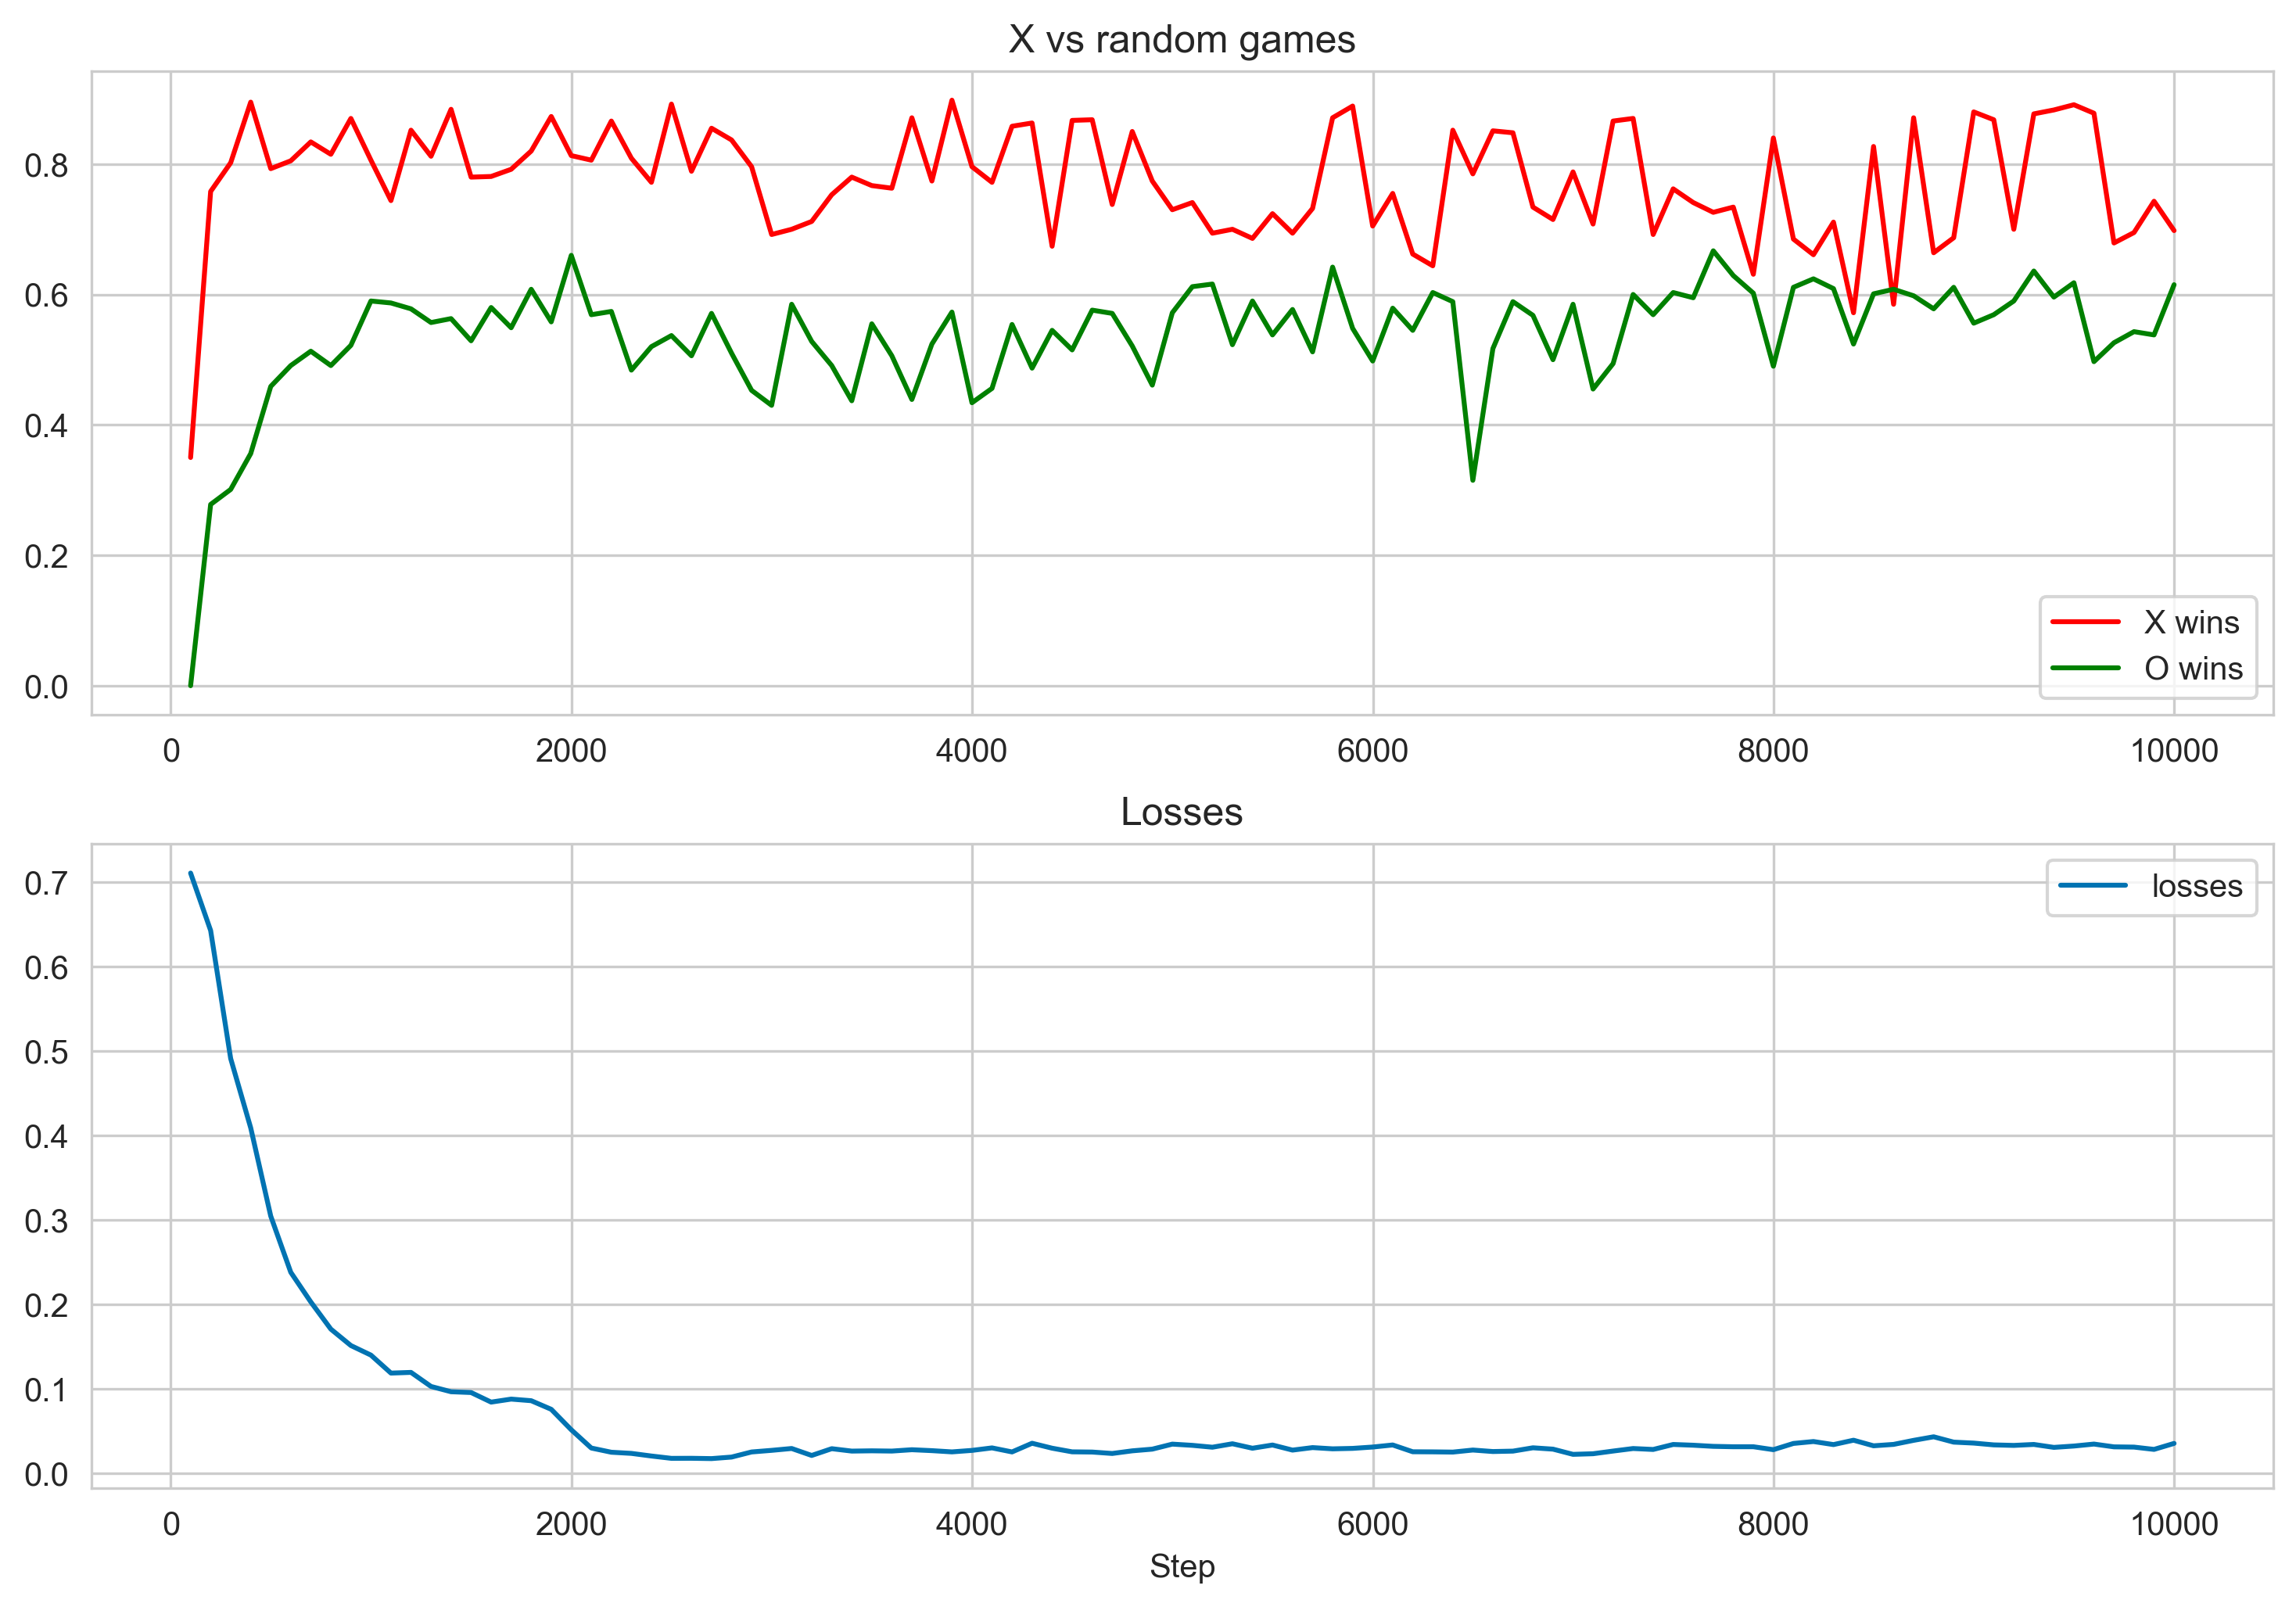

In [962]:
dqn = DQN(3, 3, 3)
test_episodes = 1000
rewards = []
losses = []
reward = []
loss = []
counter = []
episodes = []
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
NoneType = type(None)
for e in range(10000):
    reward1, loss1 = dqn.run_episode(e)
    for i in loss1:
        if type(i) is not NoneType:
            loss += [i]
    reward += [reward1]
    
    if (e+1) % 100 == 0:
        
        counter.append(e)
        losses.append(np.mean(loss))
        loss = []
        reward = []
        crosses_wins_counter, naughts_wins_counter = 0, 0
        for k in range(test_episodes):
            cross = test_game_dqn(dqn.env, dqn.model, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
                
            naughts = test_game_dqn(dqn.env, None, dqn.model, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
                
        episodes.append(e)
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        clear_output(True)
        ax[0].plot(episodes, crosses_wins, 'r', label='X wins')
        ax[0].plot(episodes, naughts_wins, 'g', label='O wins')
        ax[0].set_title('X vs random games')
        ax[0].legend()
        ax[1].plot(counter, losses, label='losses')
        ax[1].set_title('Losses')
        ax[1].set_xlabel('Step')
        plt.legend()
        plt.show()

# И для доски 3х3

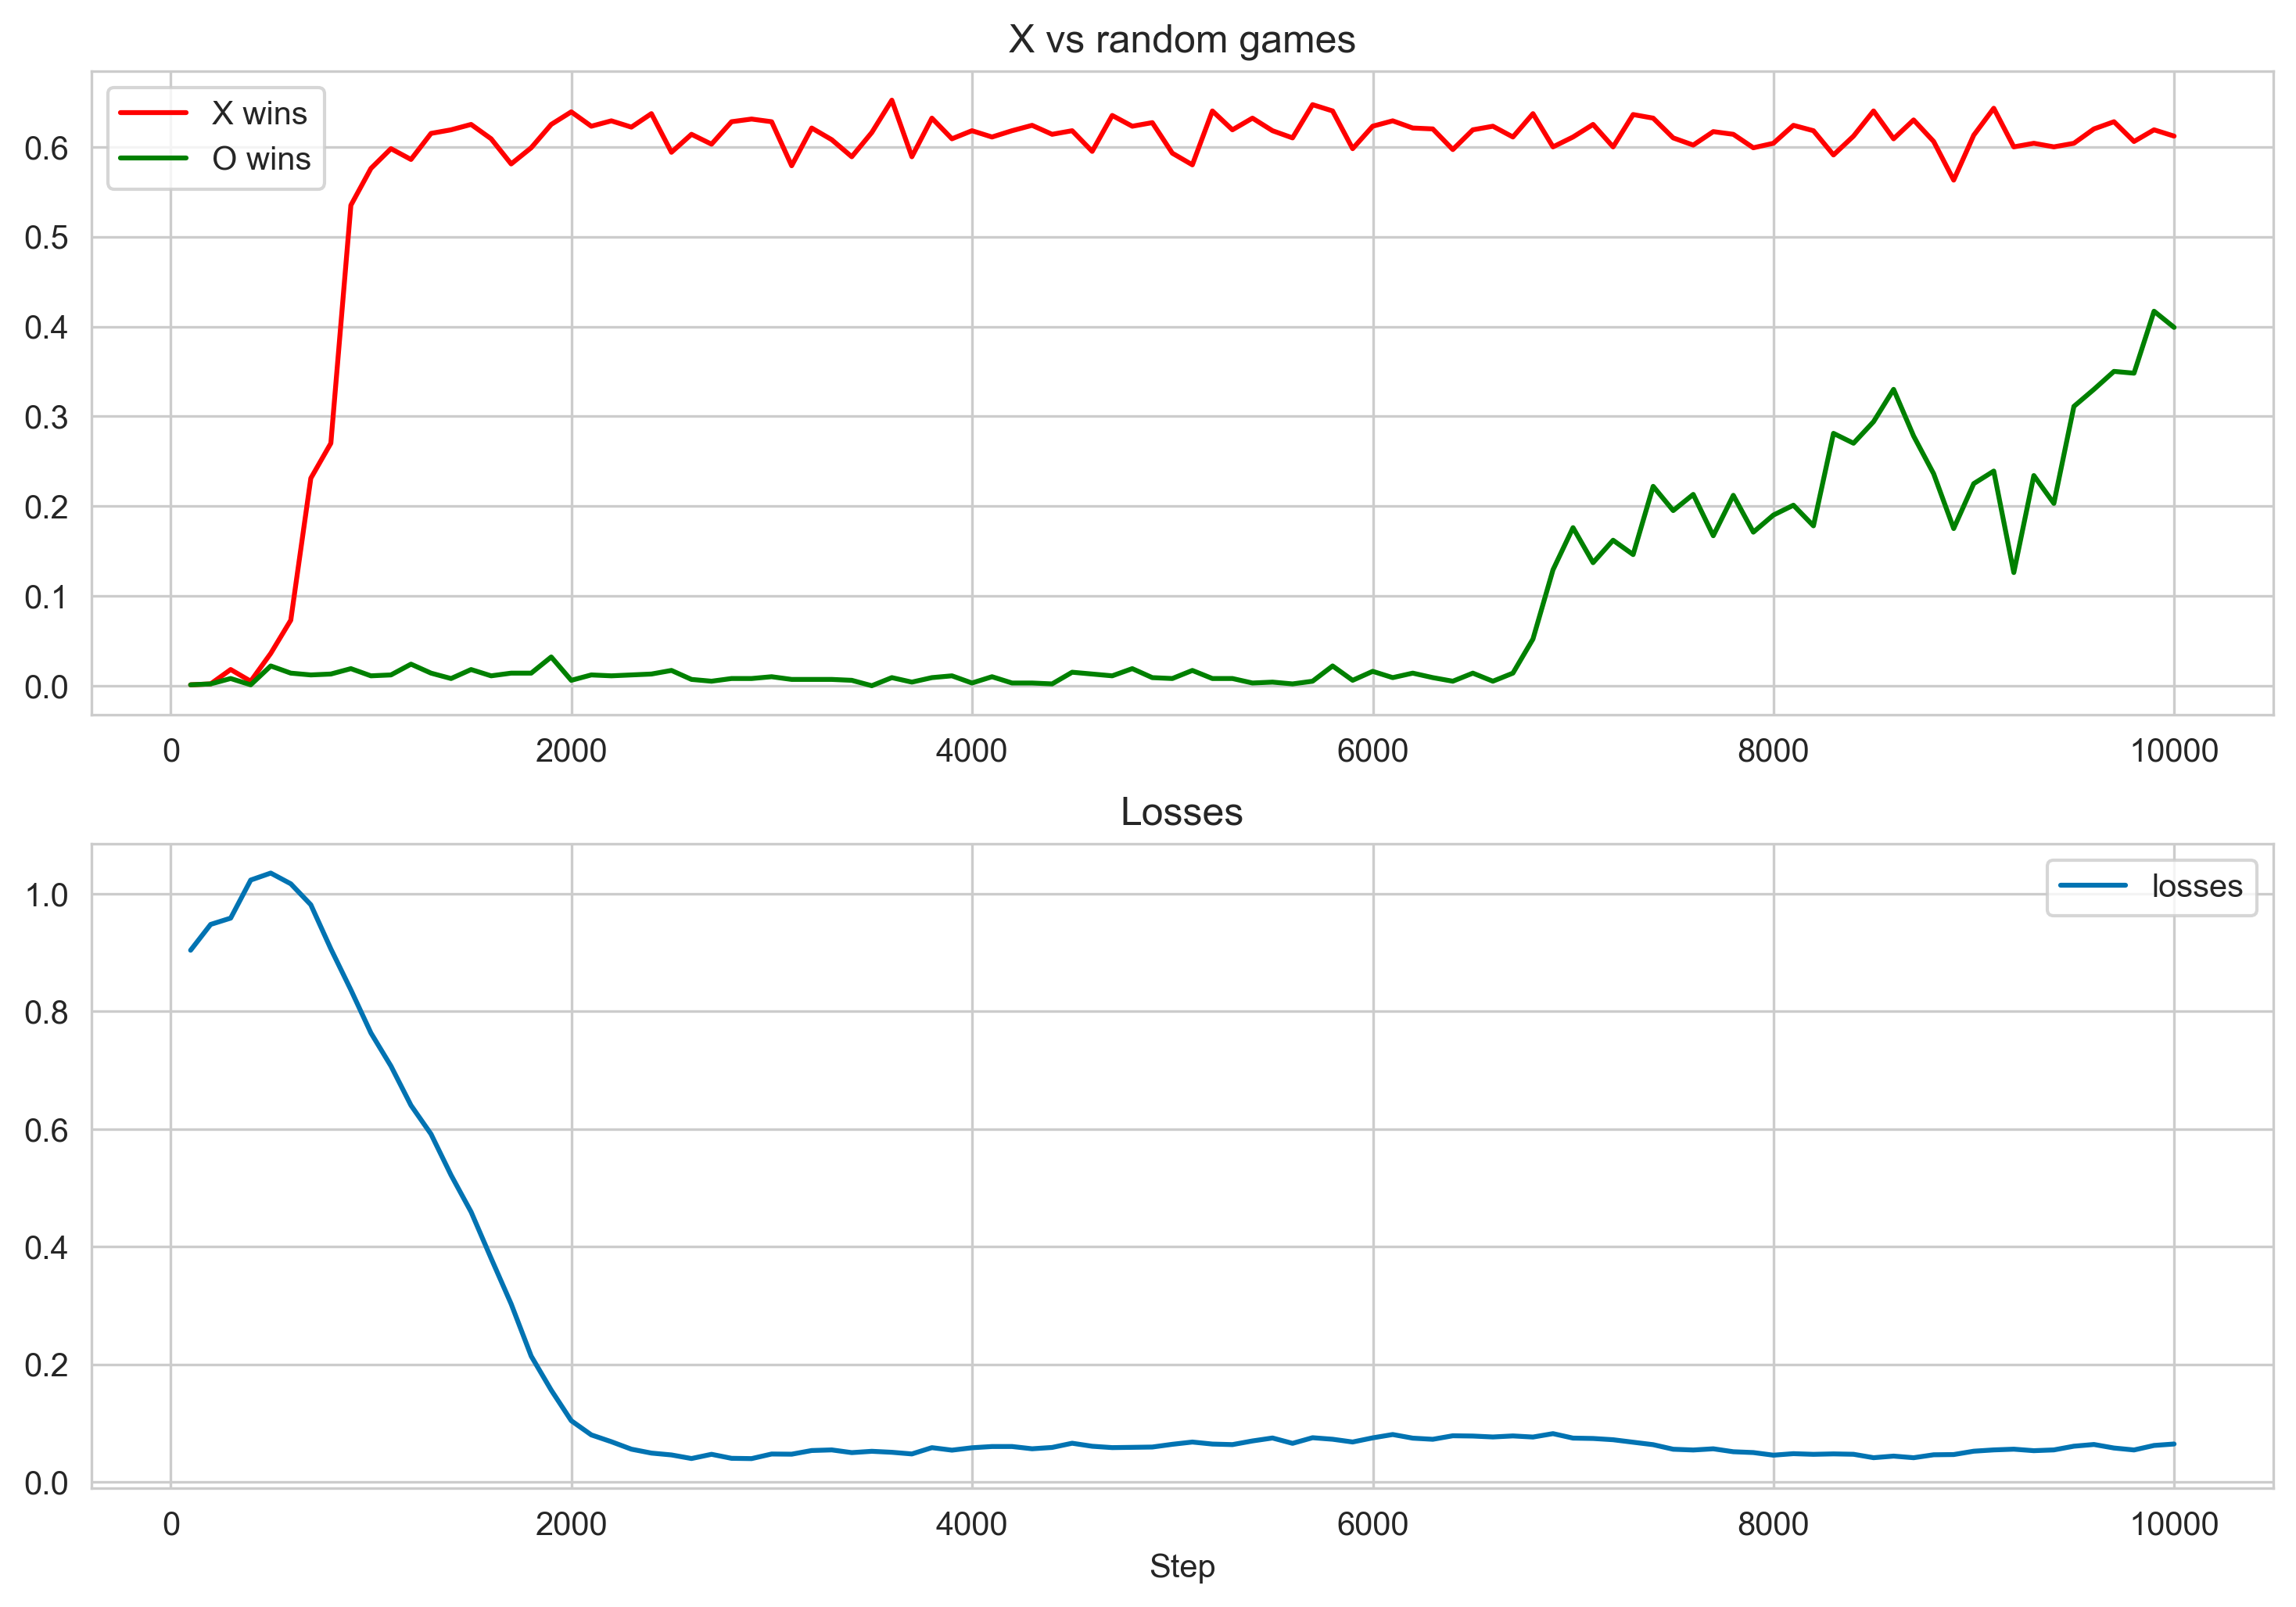

In [964]:
dqn = DQN(4, 4, 4)
test_episodes = 1000
rewards = []
losses = []
reward = []
loss = []
counter = []
episodes = []
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
NoneType = type(None)
for e in range(10000):
    reward1, loss1 = dqn.run_episode(e)
    for i in loss1:
        if type(i) is not NoneType:
            loss += [i]
    reward += [reward1]
    
    if (e+1) % 100 == 0:
        
        counter.append(e)
        losses.append(np.mean(loss))
        loss = []
        reward = []
        crosses_wins_counter, naughts_wins_counter = 0, 0
        for k in range(test_episodes):
            cross = test_game_dqn(dqn.env, dqn.model, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
                
            naughts = test_game_dqn(dqn.env, None, dqn.model, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
                
        episodes.append(e)
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        clear_output(True)
        ax[0].plot(episodes, crosses_wins, 'r', label='X wins')
        ax[0].plot(episodes, naughts_wins, 'g', label='O wins')
        ax[0].set_title('X vs random games')
        ax[0].legend()
        ax[1].plot(counter, losses, label='losses')
        ax[1].set_title('Losses')
        ax[1].set_xlabel('Step')
        plt.legend()
        plt.show()

# DoubleDQN

In [980]:
class DoubleDQN():
    def __init__(self, n_rows, n_cols, n_win, lr = 0.0001):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model = Network(n_rows, n_cols)
        self.target_model = Network(n_rows, n_cols)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), lr) # 3x3: 0.001
        
        self.nrows = n_rows
        self.ncols = n_cols
        self.n_win = n_win
        
        self.gamma = 0.7
        self.steps_done = 0
        self.episode_durations = []
        self.batch_size = 128 # 3x3: 128
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 2000
        self.target_update =500
        self.num_step = 0
        
    def select_greedy_action(self, state):
        t = self.model(state).data.max(1)[1]
        return t.view(1, 1)
    
    def state_to_matrix(self, state):
        state_matrix = [int(state[i]) for i in range(len(state))]
        return state_matrix+[self.env.curTurn]
    
    def select_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            n_sp = random.randrange(len(empty_spaces))
            act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
            return torch.tensor([[act]], dtype=torch.int64)
        
    def select_random_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        n_sp = random.randrange(len(empty_spaces))
        act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
        return torch.tensor([[act]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        if self.num_step == 0:
            self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        state = self.env.getState()
        actions = []
        losses = []
        while True:
            self.num_step += 1
            state_tensor = torch.tensor([self.state_to_matrix(state[0])], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            if (reward != -10) and(self.env.curTurn == 1):
                reward = -reward
            
            next_state_tensor = torch.tensor([self.state_to_matrix(next_state[0])], dtype=torch.float32) 
            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            actions.append(action)
            self.memory.store(transition)

            if do_learning:
                losses.append(self.learn())
            state = next_state    
            
            if self.num_step % self.target_update == 0:
                    self.target_model.load_state_dict(self.model.state_dict())

            if done:
                return reward, losses
                #break
            
                
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        # берём мини-батч из памяти
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward), requires_grad=True)
        batch_next_state = Variable(torch.cat(batch_next_state), requires_grad=True)
        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        Q_target = self.target_model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

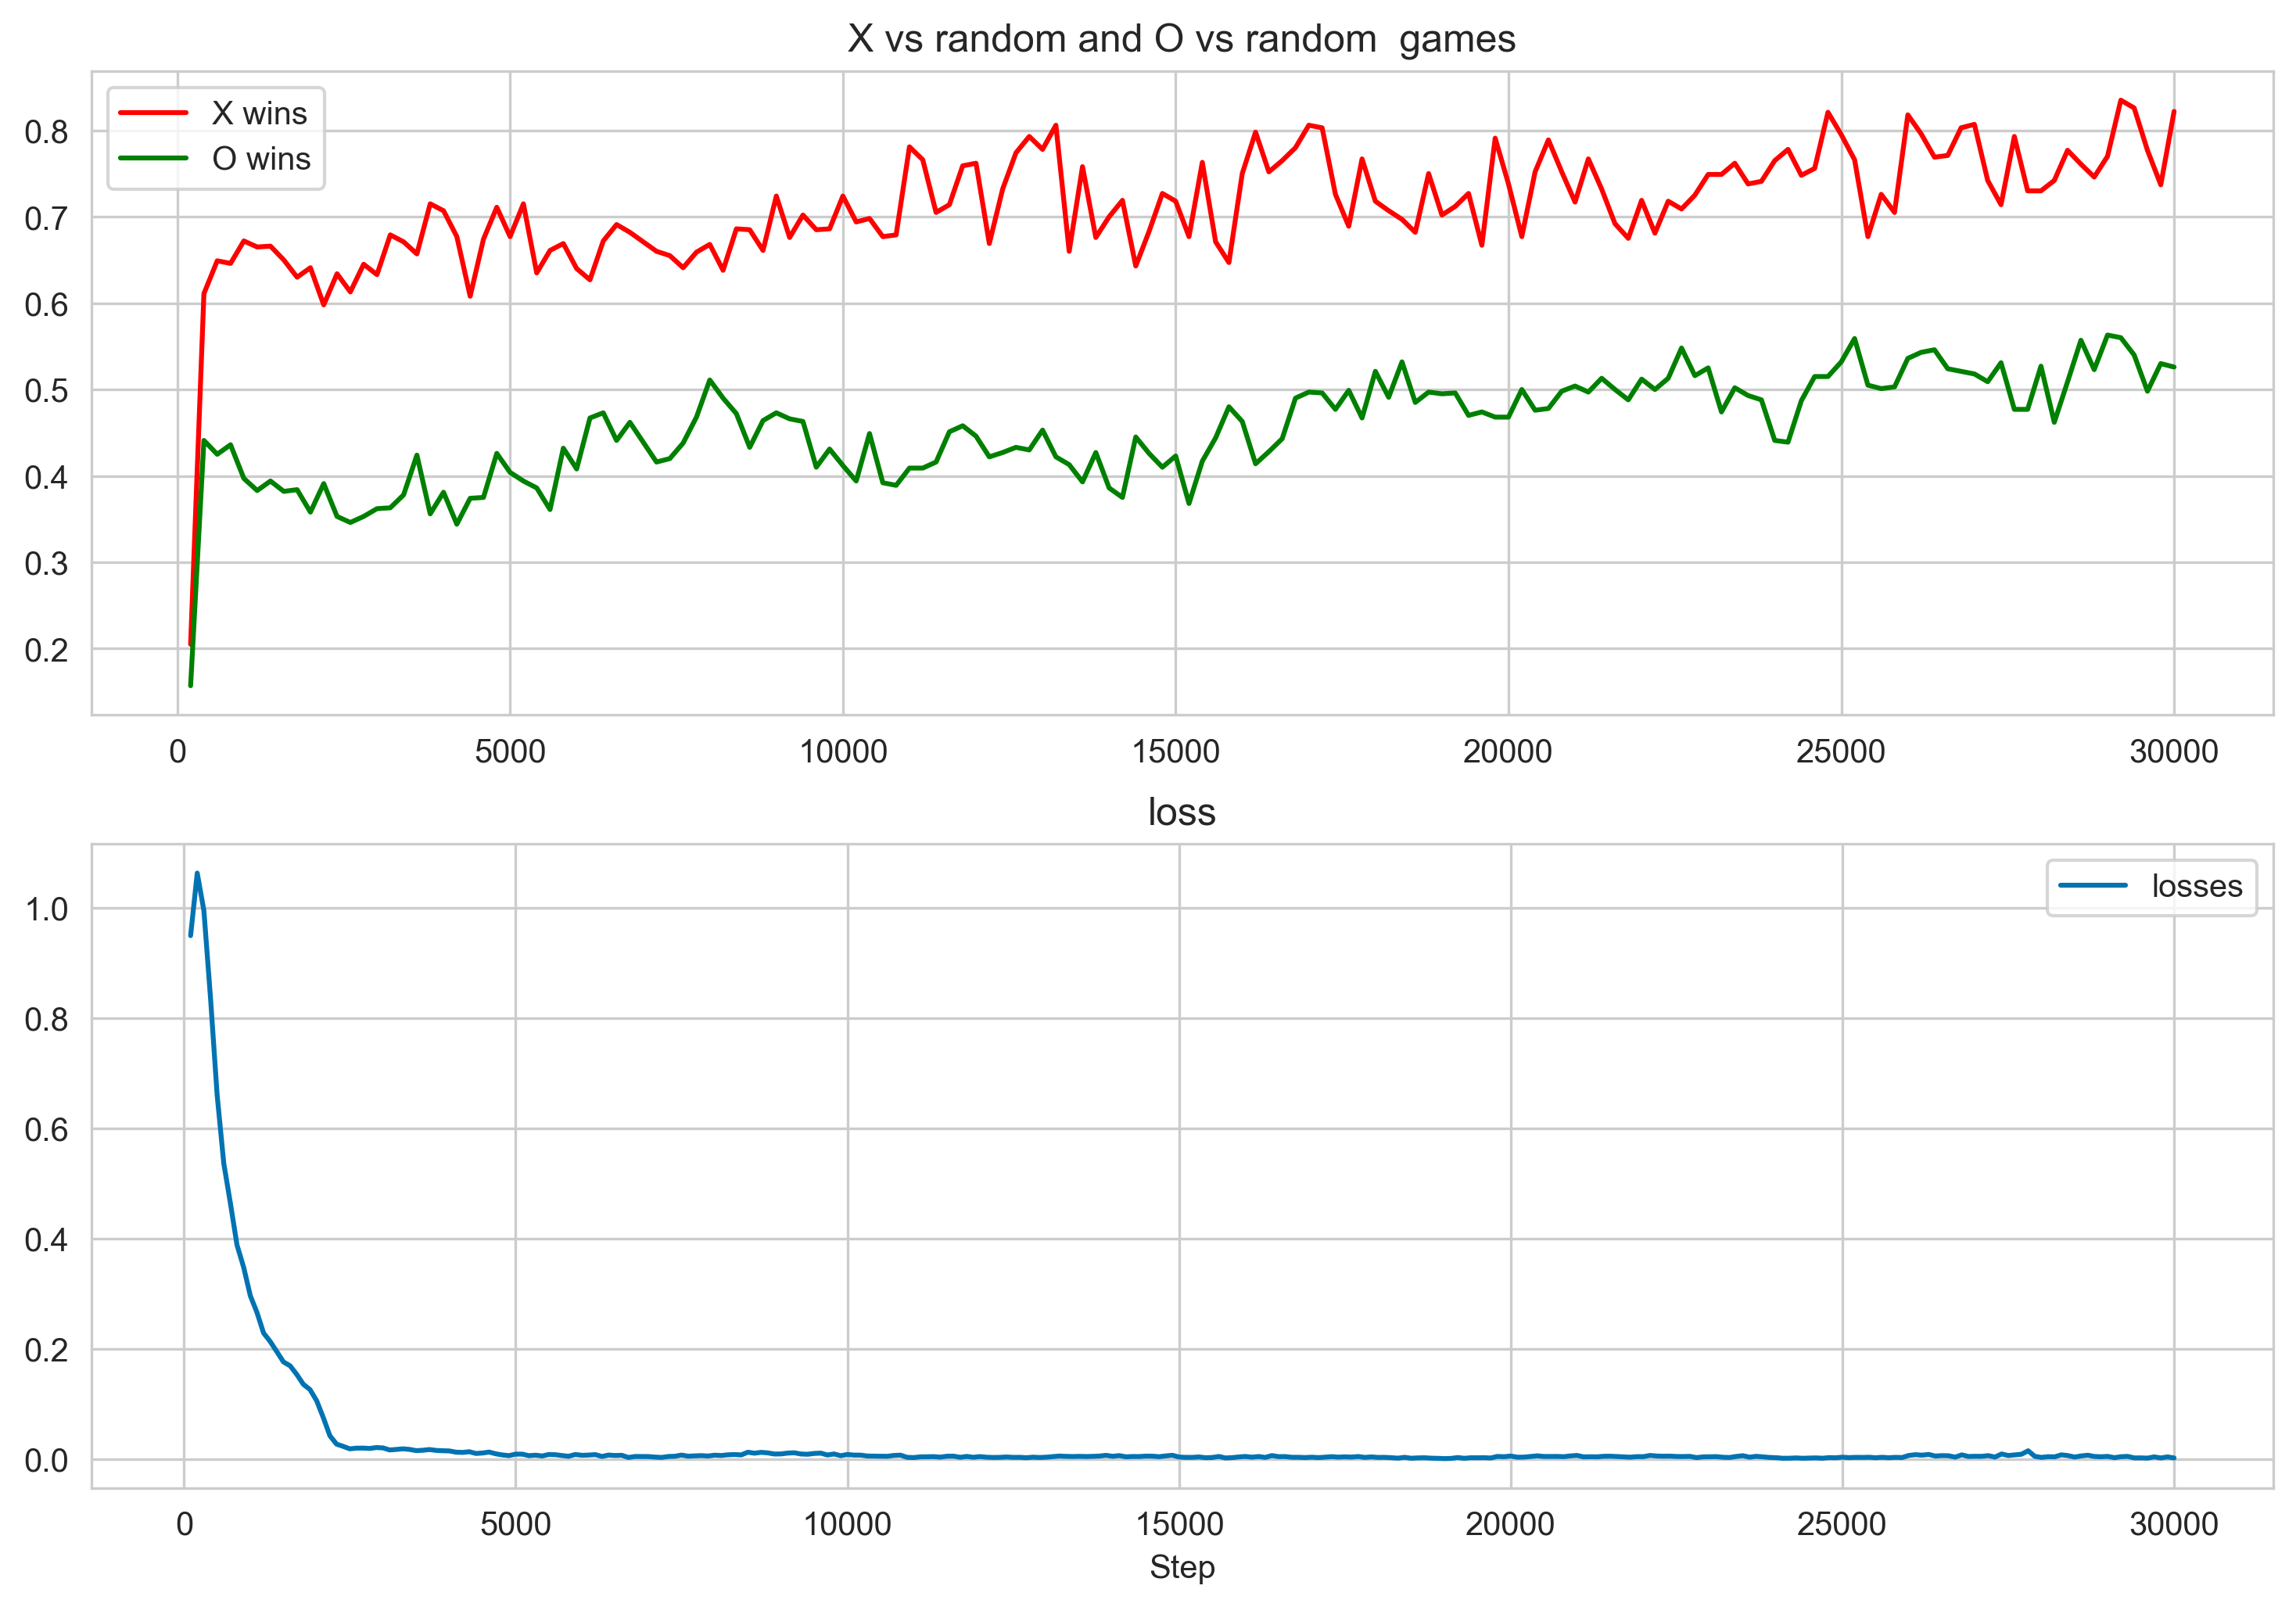

In [949]:
ddqn = DoubleDQN(3, 3, 3)
test_episodes = 1000
rewards = []
losses = []
reward = []
loss = []
counter = []
episodes = []
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
NoneType = type(None)
for e in range(100000):
    reward1, loss1 = ddqn.run_episode(e)
    for i in loss1:
        if type(i) is not NoneType:
            loss += [i]
    reward += [reward1]
    if (e+1) % 100 == 0:
        
        counter.append(e)
        losses.append(np.mean(loss))
        #fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        #clear_output(True)
        #ax[1].plot(counter, losses, label='losses')
        #plt.legend()
        #plt.show()
        loss = []
        reward = []
    
    if (e+1) % 200 == 0:
        crosses_wins_counter, naughts_wins_counter = 0, 0
        for k in range(test_episodes):
            cross = test_game_dqn(ddqn.env, ddqn.model, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
                
            naughts = test_game_dqn(ddqn.env, None, ddqn.model, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
                
        episodes.append(e)
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        clear_output(True)
        ax[0].plot(episodes, crosses_wins, 'r', label='X wins')
        ax[0].plot(episodes, naughts_wins, 'g', label='O wins')
        ax[0].set_title('X vs random and O vs random  games')
        ax[0].legend()
        ax[1].plot(counter, losses, label='losses')
        ax[1].set_title('loss')
        ax[1].set_xlabel('Step')
        plt.legend()
        plt.show()

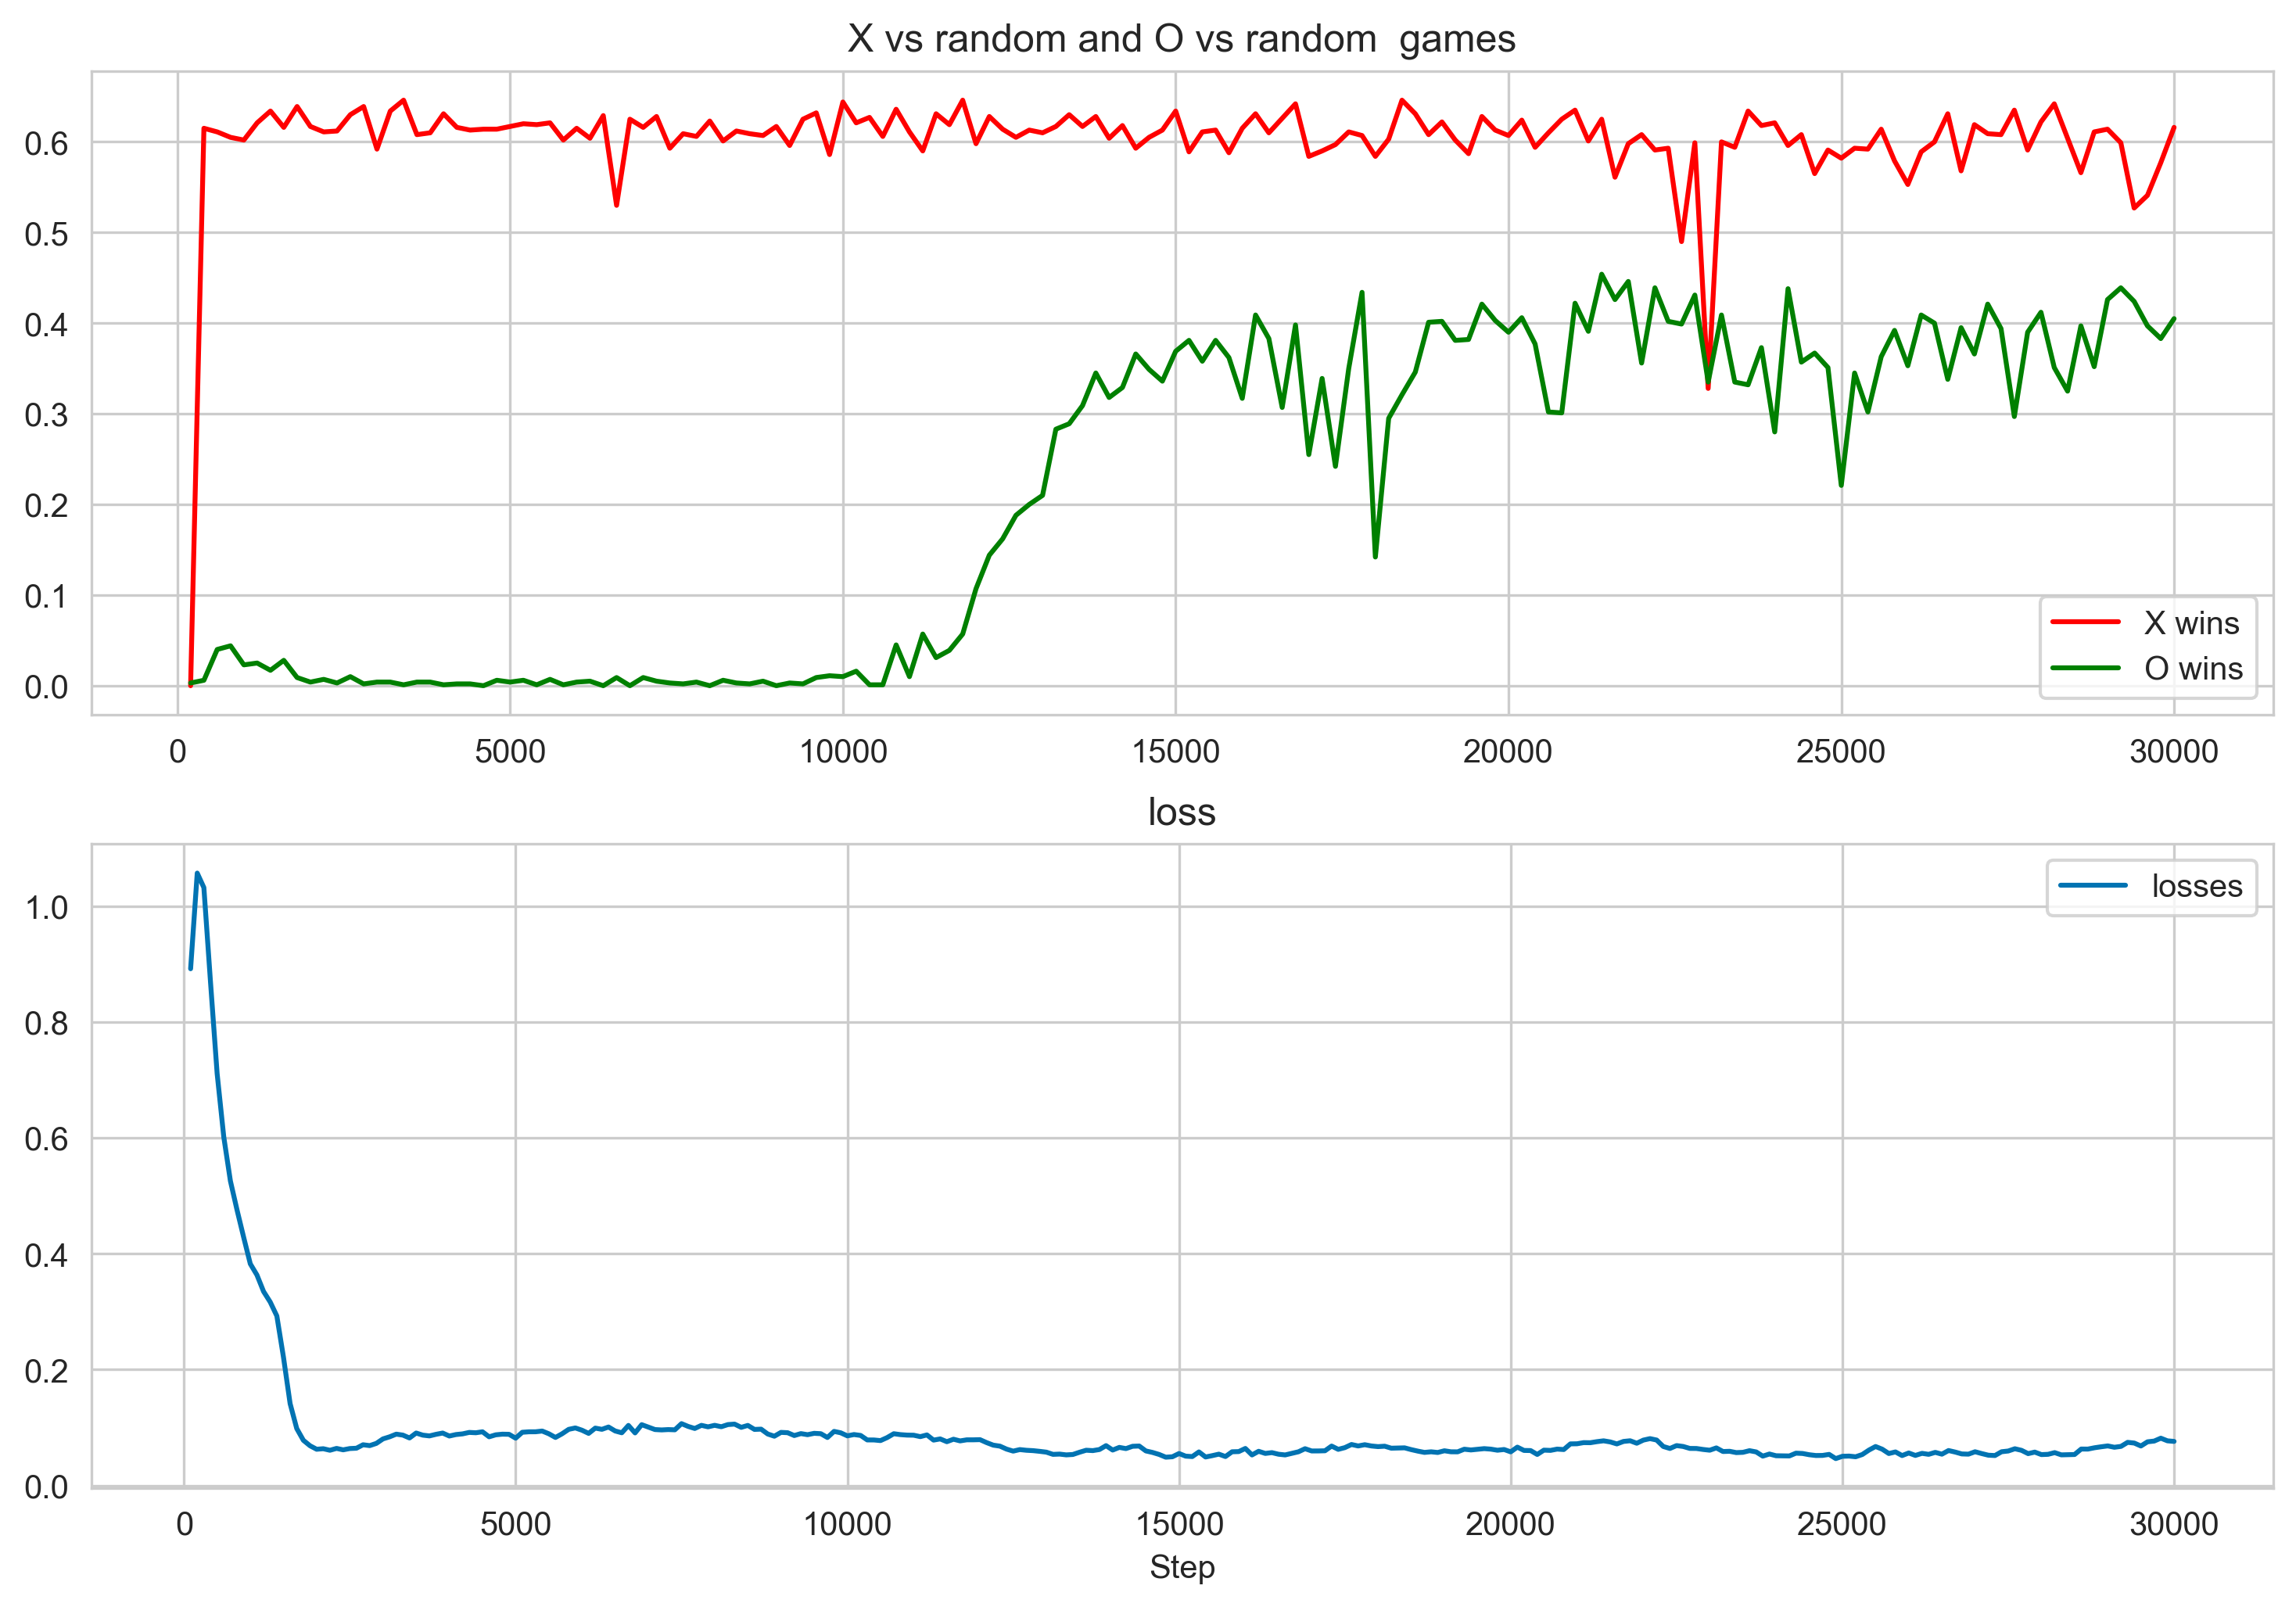

In [982]:
ddqn = DoubleDQN(4, 4, 4, 0.001)
test_episodes = 1000
rewards = []
losses = []
reward = []
loss = []
counter = []
episodes = []
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
NoneType = type(None)
for e in range(30000):
    reward1, loss1 = ddqn.run_episode(e)
    for i in loss1:
        if type(i) is not NoneType:
            loss += [i]
    reward += [reward1]
    if (e+1) % 100 == 0:
        
        counter.append(e)
        losses.append(np.mean(loss))

        loss = []
        reward = []
    
    if (e+1) % 200 == 0:
        crosses_wins_counter, naughts_wins_counter = 0, 0
        for k in range(test_episodes):
            cross = test_game_dqn(ddqn.env, ddqn.model, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
                
            naughts = test_game_dqn(ddqn.env, None, ddqn.model, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
                
        episodes.append(e)
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        clear_output(True)
        ax[0].plot(episodes, crosses_wins, 'r', label='X wins')
        ax[0].plot(episodes, naughts_wins, 'g', label='O wins')
        ax[0].set_title('X vs random and O vs random  games')
        ax[0].legend()
        ax[1].plot(counter, losses, label='losses')
        ax[1].set_title('loss')
        ax[1].set_xlabel('Step')
        plt.legend()
        plt.show()

# Реализуем rollouts

In [14]:
import copy

def do_rollouts(env, s, cur_turn, pi, num_episodes):
    
    summ_reward = 0
    if cur_turn == -1:
        pi1 = copy.deepcopy(pi)
        pi2 = None
        random_naughts = True
        random_crosses = False
    else:
        pi1 = None
        pi2 = copy.deepcopy(pi)
        random_crosses = True
        random_naughts = False
    for i in range(num_episodes):
        current_env = copy.deepcopy(env)
        done = False
        while not done:
            s, actions = current_env.getHash(), current_env.getEmptySpaces()
            if current_env.curTurn == 1:
                a = get_one_move(current_env, pi1, s, actions, random=random_crosses)
            else:
                a = get_one_move(current_env, pi2, s, actions, random=random_naughts)
            s, reward, done, info = current_env.step(a)
            if current_env.curTurn == 1 and reward != -10:
                reward = -reward
            summ_reward += reward
    return summ_reward/num_episodes

In [21]:
def test_game_with_rollouts(env, pi1, pi2, random_crosses=False, random_naughts=True):
    done = False
    env.reset()
    if random_naughts: #играем за Х против рандомной стратегии О
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            #ход Х
            if env.curTurn == 1: 
                rollout_results = {}
                current_env = copy.deepcopy(env)
                for act in actions:
                    curr_a = current_env.int_from_action(act)
                    s, reward, done, info = current_env.step(curr_a)
                    if not(done):
                        rollout_result = do_rollouts(current_env, s, pi1, current_env.curTurn, 100)
                    else:
                        rollout_result = reward
                    rollout_results.update({curr_a:rollout_result})
                a = max(rollout_results, key=lambda k: rollout_results[k])
                pi.update({s[0]:a})
            else: #ход О
                a = get_one_move(env, pi2, s, actions, random=random_naughts)
            observation, reward, done, info = env.step(a)
    else: #играем за О против рандомной стратегии Х
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == -1:
                rollout_results = {}
                current_env = copy.deepcopy(env)
                for act in actions:
                    curr_a = current_env.int_from_action(act)
                    s, reward, done, info = current_env.step(curr_a)
                    if not(done):
                        rollout_result = do_rollouts(current_env, s, pi2, current_env.curTurn, 100)
                    else:
                        rollout_result = reward if reward == -10 else -reward
                    rollout_results.update({curr_a:rollout_result})
                a = max(rollout_results, key=lambda k: rollout_results[k])
                pi.update({s[0]:a})
            else:
                a = get_one_move(env, pi1, s, actions, random=random_crosses)
            observation, reward, done, info = env.step(a)
    return reward

# Протестирует на "немного обученной" cтратегии

In [24]:
total_episodes = 50000
test_episodes = 1000
gamma = 0.8
N_ROWS, N_COLS, N_WIN = 4, 4, 4
Q_hist_Qlearn = [ ]
Q = {}
pi = {}

env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
episodes = []
for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.5, gamma=gamma)
    pi = compute_policy_by_Q(Q, pi)
    Q_hist_Qlearn.append(np.copy(Q))
env.close()
pi = compute_policy_by_Q(Q, pi)

In [25]:
rollout_result_crosses, result_crosses, rollout_result_naughts, result_naughts = 0, 0, 0, 0
total_episodes = 1000
for i in range(total_episodes):
    #крестики
    if test_game_with_rollouts(env, pi, None, random_crosses=False, random_naughts=True) == 1:
        rollout_result_crosses += 1
    if test_game(env, pi, None, random_crosses=False, random_naughts=True) == 1:
        result_crosses += 1
    #нолики
    if test_game_with_rollouts(env, None, pi, random_crosses=True, random_naughts=False) == -1:
        rollout_result_naughts += 1
    if test_game(env,  None, pi, random_crosses=True, random_naughts=False) == -1:
        result_naughts += 1
    
print("X wins %d games with rollouts and %d without rollouts out of %d games" %(rollout_result_crosses, result_crosses, total_episodes))
print("O wins %d games with rollouts and %d without rollouts out of %d games" %(rollout_result_naughts, result_naughts, total_episodes))

X wins 892 games with rollouts and 27 without rollouts out of 1000 games
O wins 696 games with rollouts and 1 without rollouts out of 1000 games


# Результаты использования rollouts заметно лучше, чем без него.